<div class="alert alert-block alert-info">
<b>How to run this notebook?</b><br />
<ol>
    <li>Install the DockStreamFull environment: conda env create -f environment_full.yml in the DockStream directory</li>
    <li>Activate the environment: conda activate DockStreamCommunity</li>
    <li>Execute jupyter: jupyter notebook</li>
    <li> Copy the link to a browser</li>
    <li> Update variables <b>dockstream_path</b> and <b>dockstream_env</b> (the path to the environment DockStream) in the 
        first code block below</li>
    </ol>
</div>

<div class="alert alert-block alert-warning">
    <b>Caution:</b><br />
    The difference between the DockStream and DockStreamFull environments is that the latter is required for any GOLD 
    related experiments. Make sure you use the full environment for any runs with Gold as the backend. Also 
    check beforehand whether the CCDC Software Activation has been completed successfully.
</div>

# `Gold` backend demo
This notebook will demonstrate how to **(a)** set up a `Gold` backend run with `DockStream`, including the most important settings and **(b)** how to set up a `REINVENT` run with `Gold` docking enabled as one of the scoring function components.

**Steps:**
* a: Set up `DockStream` run
  1. Prepare the receptor
  2. Prepare the input: SMILES and configuration file (JSON format)
  3. Execute the docking and parse the results
* b: Set up `REINVENT` run with a `DockStream` component
  1. Prepare the receptor (see *a.1*)
  2. Prepare the input (see *a.2*)
  3. Prepare the `REINVENT` configuration (JSON format)
  4. Execute `REINVENT`

If a `CCDC` license is available, `DockStream` can make use of its target preparation and docking capabilities. The environment variable _CSDHOME_ needs to be set to the `ccdc` folder. __Note:__ Make sure, you have activated the `DockStream` environment before launching this notebook. This notebook will deposit all files created into `~/Desktop/Gold_demo`.

The following imports / loadings are only necessary when executing this notebook. If you want to use `DockStream` directly from the command-line, it is enough to execute the following with the appropriate configurations:

```
conda activate DockStreamFull
python /path/to/DockStream/target_preparator.py -conf target_prep.json
python /path/to/DockStream/docker.py -conf docking.json
```

In [1]:
import os
import json
import tempfile

# update these paths to reflect your system's configuration
dockstream_path = os.path.expanduser("~/Desktop/ProjectData/DockStream")
dockstream_env = os.path.expanduser("~/miniconda3/envs/DockStreamFull")

# no changes are necessary beyond this point
# ---------
# get the notebook's root path
try: ipynb_path
except NameError: ipynb_path = os.getcwd()

# generate the paths to the entry points
target_preparator = dockstream_path + "/target_preparator.py"
docker = dockstream_path + "/docker.py"

# generate a folder to store the results
output_dir = os.path.expanduser("~/Desktop/Gold_demo")
try:
    os.mkdir(output_dir)
except FileExistsError:
    pass

In [2]:
# generate the paths to the files shipped with this implementation
apo_1UYD_path = ipynb_path + "/../data/1UYD/1UYD_apo.pdb"
reference_ligand_path = ipynb_path + "/../data/1UYD/PU8.pdb"
smiles_path = ipynb_path + "/../data/1UYD/ligands_smiles.txt"

# generate output paths for the configuration file, the "fixed" PDB file and the "Gold" receptor
target_prep_path = output_dir + "/Gold_target_prep.json"
fixed_pdb_path = output_dir + "/Gold_fixed_target.pdb"
gold_receptor_path = output_dir + "/Gold_receptor.pkl"

# generate output paths for the configuration file, embedded ligands, the docked ligands and the scores
docking_path = output_dir + "/Gold_docking.json"
ligands_conformers_path = output_dir + "/Gold_embedded_ligands.sdf"
ligands_docked_path = output_dir + "/Gold_ligands_docked.sdf"
ligands_scores_path = output_dir + "/Gold_scores.csv"

## Target preparation
`Gold` has no receptor format on its own, so we will pack all necessary specifications into a "pickled" file to be used for the docking later. This is a semi-automated process and while `DockStream` has an entry point to help you setting this up, it might be wise to think about the details of this process beforehand, including:
* Is my target structure complete (e.g. has it missing loops in the area of interest)?
* Do I have a reference ligand in a complex (holo) structure or do I need to define the binding cleft (cavity) in a different manner?
* Do I want to keep the crystal water molecules, potential co-factors and such or not?

This step has to be done once per project and target. Typically, we start from a PDB file with a holo-structure, that is, a protein with its ligand. Using a holo-structure as input is convenient for two reasons:
1. The cavity can be specified as being a certain area around the ligand in the protein (assuming the binding mode does not change too much).
2. One can align other ligands (often a series with considerable similarity is used in docking studies) to the "reference ligand", potentially improving the performance.

While `Gold` allows you to generate the cavity specification using other approaches as well, they are not yet implemented in `DockStream`.

![](img/target_preparation_template_method.png)

For this notebook, it is assumed that you are able to

1. download `1UYD` and
2. split it into `1UYD_apo.pdb` and `reference_ligand.pdb` (name is `PU8` in the file), respectively.

We will now set up the JSON instruction file for the target preparator that will help us build a receptor suitable for `Gold` docking later. We will also include a small section (internally using [PDBFixer](https://github.com/openmm/pdbfixer)) that will take care of minor problems of the input structure, such as missing hetero atoms - but of course you can address these things with a program of your choice as well. We will write the JSON to the output folder in order to load it with the `target_preparator.py` entry point of `DockStream`. Also note, that `DockStream` will perform some standard adaptions for the target such as protonation automatically.

In [3]:
# specify the target preparation JSON file as a dictionary and write it out
tp_dict = {
  "target_preparation":
  {
    "header": {                                   # general settings
      "environment": {
        "export": [{                              # while you may also load the "Gold" license file variable
                                                  # console, this block allows to export environment variables
                                                  # for each run as well
                "key": "CSDHOME",
                "value": "/opt/scp/software/ccdc/2020.0.1/CSD_2020" }]
      }
    },
    "input_path": apo_1UYD_path,                  # this should be an absolute path
    "fixer": {                                    # based on "PDBFixer"; tries to fix common problems with PDB files
      "enabled": True,
      "standardize": True,                        # enables standardization of residues
      "remove_heterogens": True,                  # remove hetero-entries
      "fix_missing_heavy_atoms": True,            # if possible, fix missing heavy atoms
      "fix_missing_hydrogens": True,              # add hydrogens, which are usually not present in PDB files
      "fix_missing_loops": False,                 # add missing loops; CAUTION: the result is usually not sufficient
      "add_water_box": False,                     # if you want to put the receptor into a box of water molecules
      "fixed_pdb_path": fixed_pdb_path            # if specified and not "None", the fixed PDB file will be stored here
    },
    "runs": [                                     # "runs" holds a list of backend runs; at least one is required
      {
        "backend": "Gold",                        # one of the backends supported ("Gold", "OpenEye", ...)
        "output": {
          "receptor_path": gold_receptor_path     # the generated receptor file will be saved to this location
        },
        "parameters": {},
        "cavity": {                               # there are different ways to specify the cavity; here, a reference
                                                  # ligand is used
          "method": "reference_ligand",
          "reference_ligand_path": reference_ligand_path,
          "distance": 7.0                         # cavity range around the reference ligand in Angstrom
}}]}}

with open(target_prep_path, 'w') as f:
    json.dump(tp_dict, f, indent=2)

In [4]:
# execute this in a command-line environment after replacing the parameters
!{dockstream_env}/bin/python {target_preparator} -conf {target_prep_path}

This is it, now we have **(a)** fixed some minor issues with the input structure and **(b)** generated a reference ligand-based receptor and stored it in a binary file. For inspection later, we will write out the "fixed" PDB structure (parameter `fixed_pdb_path` in the `fixer` block above).

## Docking
In this section we consider a case, where we have just prepared the receptor and want to dock a bunch of ligands (molecules, compounds) into the binding cleft. Often, we only have the structure of the molecules in the form of `SMILES`, rather than a 3D structure so the first step will be to generate these conformers before proceeding. In `DockStream` you can embed your ligands with a variety of programs including `Corina`, `RDKit`, `OMEGA`, and `LigPrep` and use them freely with any backend. Here we will use `Corina` for the conformer embedding.

But first, we will have a look at the ligands:

In [5]:
# load the smiles (just for illustrative purposes)
# here, 15 moleucles will be used
with open(smiles_path, 'r') as f:
    smiles = [smile.strip() for smile in f.readlines()]
print(smiles)

['C#CCCCn1c(Cc2cc(OC)c(OC)c(OC)c2Cl)nc2c(N)ncnc21', 'CCCCn1c(Cc2cc(OC)c(OC)c(OC)c2)nc2c(N)ncnc21', 'CCCCn1c(Cc2cc(OC)ccc2OC)nc2c(N)ncnc21', 'CCCCn1c(Cc2cccc(OC)c2)nc2c(N)ncnc21', 'C#CCCCn1c(Cc2cc(OC)c(OC)c(OC)c2Cl)nc2c(N)nc(F)nc21', 'CCCCn1c(Cc2ccc(OC)cc2)nc2c(N)ncnc21', 'CCCCn1c(Cc2ccc3c(c2)OCO3)nc2c(N)ncnc21', 'CCCCn1c(Cc2cc(OC)ccc2OC)nc2c(N)nc(F)nc21', 'CCCCn1c(Cc2ccc3c(c2)OCO3)nc2c(N)nc(F)nc21', 'C#CCCCn1c(Cc2cc(OC)ccc2OC)nc2c(N)nc(F)nc21', 'CC(C)NCCCn1c(Cc2cc3c(cc2I)OCO3)nc2c(N)nc(F)nc21', 'CC(C)NCCCn1c(Sc2cc3c(cc2Br)OCO3)nc2c(N)ncnc21', 'CC(C)NCCCn1c(Sc2cc3c(cc2I)OCO3)nc2c(N)ncnc21', 'COc1ccc(OC)c(Cc2nc3nc(F)nc(N)c3[nH]2)c1', 'Nc1nccn2c(NCc3ccccc3)c(Cc3cc4c(cc3Br)OCO4)nc12']


While the embedding and docking tasks in `DockStream` are both specified in the same configuration file, they are handled independently. This means it is perfectly fine to either load conformers (from an `SDF` file) directly or to use a call of `docker.py` merely to generate conformers without doing the docking afterwards.

`DockStream` uses the notion of (embedding) "pool"s, of which multiple can be specified and accessed via identifiers. Note, that while the way conformers are generated is highly backend specific, `DockStream` allows you to use the results interchangably. This allows to (a) re-use embedded molecules for multiple docking runs (e.g. different scoring functions), without the necessity to embed them more than once and (b) to combine embeddings and docking backends freely.

One important feature is, that you can also specify an `align` block for the pools, which will try to align the conformers produced to the reference ligand's coordinates. Alignment is especially useful if your molecules have a large common sub-structure, as it will potentially enhance the results. **Warning:** At the moment, this feature is a bit unstable at times (potentially crashes, if no overlap of a ligand with the reference ligand can be found).

In [ ]:
# specify the embedding and docking JSON file as a dictionary and write it out
ed_dict = {
  "docking": {
    "header": {                                         # general settings
      "environment": {
        "export": [{
            "key": "CSDHOME",
            "value": "/opt/scp/software/ccdc/2020.0.1/CSD_2020"
        }]
      }
    },
    "ligand_preparation": {                             # the ligand preparation part, defines how to build the pool
      "embedding_pools": [
        {
          "pool_id": "Corina_pool",                     # here, we only have one pool
          "type": "Corina",
          "parameters": {
            "prefix_execution": "module load corina"    # only required, if a module needs to be loaded to execute "Corina"
          },
          "input": {
            "standardize_smiles": False,
            "type": "smi",
            "input_path": smiles_path
          },
          "output": {                                   # the conformers can be written to a file, but "output" is
                                                        # not required as the ligands are forwarded internally
            "conformer_path": ligands_conformers_path, 
            "format": "sdf"
          }
        }
      ]
    },
    "docking_runs": [
      {
        "backend": "Gold",                               # specify the backend
        "run_id": "Gold_run",                            # give any (unique) run ID
        "input_pools": ["Corina_pool"],                  # select, which pools should be used as input
        "parameters": {                                  # these are backend-specific parameters
          "prefix_execution": "module load ccdc/2020.0.1",
          "receptor_paths": [gold_receptor_path],
          "fitness_function": "plp",                     # choose the fitness function from: "plp" (default),
                                                         # "chemscore", "goldscore" and "asp"
          "early_termination": False,                    # stop, if the number of solutions is met
          "autoscale": 25,                               # number of genetic operations (cross-over, migration and
                                                         # mutation) performed (see text for details)
          "ndocks": 1                                    # number of docking poses from random population
                                                         # note, that the higher this number, the slower the execution
        },
        "output": {
          "poses": { "poses_path": ligands_docked_path },
          "scores": { "scores_path": ligands_scores_path }
}}]}}

with open(docking_path, 'w') as f:
    json.dump(ed_dict, f, indent=2)

# print out path to generated JSON
print(docking_path)

There is one very important paramter set above that controls the accuracy-speed trade-off the most: `autoscale`. It must be a positive integer number and typically is somewhere between 25 (very fast, not very accurate) and 100 (pretty slow, higher accuracy).

In [7]:
# execute this in a command-line environment after replacing the parameters
!{dockstream_env}/bin/python {docker} -conf {docking_path} -print_scores

73.2913
77.8404
65.7641
64.4136
80.2781
65.6716
73.0389
76.0957
64.0282
69.6312
69.1131
65.1061
76.599
61.4074
71.2672


Note, that the scores are usually only outputted to a `CSV` file specified by the `scores` block, but that since we have used parameter `-print_scores` they will also be printed to `stdout` (line-by-line).

These scores are associated with docking poses (see picture below for a couple of ligands overlaid in the binding pocket).

![](img/docked_ligands_overlay_holo.png)

### How to run it on a cluster?
The `CCDC`/`Gold` API may require an `X11 interface`, which is usually not available on cluster nodes. In order to execute it, you will need to set environment variable `QT_QPA_PLATFORM` to "offscreen", e.g. for `SLURM`'s command-line interface `sbatch`:

```
sbatch --export=QT_QPA_PLATFORM="offscreen" <your_script>.sh
```

## Using `DockStream` as a scoring component in `REINVENT`
The *de novo* design platform `REINVENT` holds a recently added `DockStream` scoring function component (also check out our collection of notebooks in the [ReinventCommunity](https://github.com/MolecularAI/ReinventCommunity) repository). This means, provided that all necessary input files and configurations are available, you may run `REINVENT` and incorporate docking scores into the score of the compounds generated. Together with `FastROCS`, this represents the first step to integrate physico-chemical 3D information.

While the docking scores are a very crude proxy for the actual binding affinity (at best), it does prove useful as a *geometric filter* (removing ligands that obviously do not fit the binding cavity). Furthermore, a severe limitation of knowledge-based predictions e.g. in activity models is the domain applicability. Docking, as a chemical space agnostic component, can enhance the ability of the agent for scaffold-hopping, i.e. to explore novel sub-areas in the chemical space.

### The `REINVENT` configuration JSON

While every docking backend has its own configuration (see section above), calling `DockStream`'s `docker.py` entry point ensures, that they all follow the same external API. Thus the component that needs to be added to `REINVENT`'s JSON configuration (to the `scoring_function`->`parameters` list) looks as follows for `Gold`:

```
{
    "component_type": "dockstream",
    "name": "dockstream",
    "weight": 1,
    "specific_parameters": {
        "transformation": {
            "transformation_type": "sigmoid",
            "low": 60,
            "high": 100,
            "k": 0.25
         },
        "configuration_path": "<absolute_path_to_DockStream_configuration>/docking.json",
        "docker_script_path": "<absolute_path_to_DockStream_source>/docker.py",
        "environment_path": "<absolute_path_to_miniconda_installation>/envs/DockStream/bin/python"
    }
}
```

You will need to update `configuration_path`, `docker_script_path` and the link to the environment, `environment_path` to match your system's configuration. It might be, that the latter two are already set to meaningful defaults, but your `DockStream` configuration JSON file will be specific for each run. 

#### How to find an appropriate transformation?
The "right" transformation depends on the backend and the scoring function. In constrast to many others, `Gold` uses fitness functions by default for which _higher_ values mean "better" (ranther than _the more negative the better_ as for e.g. `Glide`). Thus, we will use a *sigmoid* score transformation (rather than *reverse sigmoid*) to bring the numeric, continuous value that was outputted by `DockStream` and fed back to `REINVENT` into a 0 to 1 regime. The parameters `low`, `high` and `k` are critical: their exact value naturally depends on the backend used, but also on the scoring function and potentially also the project. The values reported here can be used as rule-of-thumb for an `Gold` run with `PLP` docking (fitness) score.

In [8]:
# load the dependencies and classes used
%run code/score_transformation.py

# set plotting parameters
small = 12
med = 16
large = 22
params = {"axes.titlesize": large,
          "legend.fontsize": med,
          "figure.figsize": (16, 10),
          "axes.labelsize": med,
          "axes.titlesize": med,
          "xtick.labelsize": med,
          "ytick.labelsize": med,
          "figure.titlesize": large}
plt.rcParams.update(params)
plt.style.use("seaborn-whitegrid")
sns.set_style("white")
%matplotlib inline

# set up Enums and factory
tt_enum = TransformationTypeEnum()
csp_enum = ComponentSpecificParametersEnum()
factory = TransformationFactory()

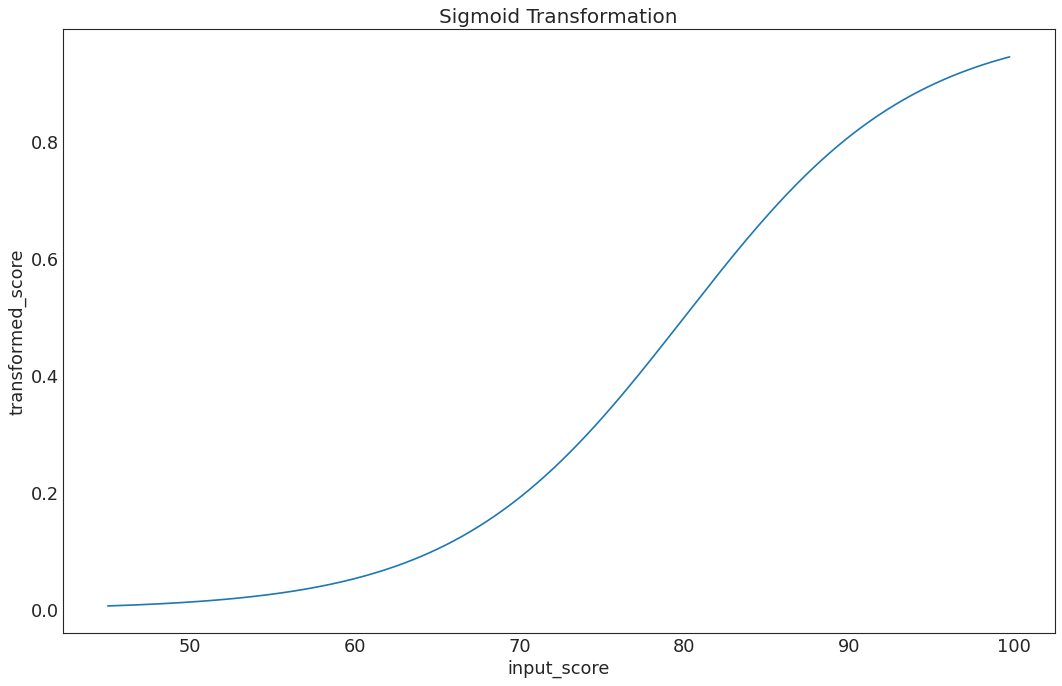

In [9]:
# sigmoid transformation
# ---------
values_list = np.arange(45, 100, 0.25).tolist()
specific_parameters = {csp_enum.TRANSFORMATION: True,
                       csp_enum.LOW: 60,
                       csp_enum.HIGH: 100,
                       csp_enum.K: 0.25,
                       csp_enum.TRANSFORMATION_TYPE: tt_enum.SIGMOID}
transform_function = factory.get_transformation_function(specific_parameters)
transformed_scores = transform_function(predictions=values_list,
                                        parameters=specific_parameters)

# render the curve
render_curve(title="Sigmoid Transformation", x=values_list, y=transformed_scores)

### How to specify the `DockStream` configuration file?
In principle, all options that are supported in a "normal" `DockStream` run (see above) are supported for usage with `REINVENT` as well, with a few notable exceptions. First, as we report only one value per ligand (and a "consensus score" is not yet supported), you should only use **one** embedding / pool and **one** backend (as in the example above). Second, the prospective ligands are not supplied via a file but from `stdin`, thus we will need to change the `input` part of the pool definition. Also, we might not want to write-out all conformers, so we will remove the `output` block entirely. The updated section then looks as follows:

```
{
    "pool_id": "Corina_pool",
    "type": "Corina",
    "parameters": {
        "removeHs": False
     },
     "input": {
         "standardize_smiles": False
     }
}
```

Finally, we will update the docking run as well. Typically, we want to see the docked poses per epoch and maybe also the scores and the SMILES in a well-tabulated format. Thus, we might retain the `output` block here, but as every epoch generates each of the files, it would overwrite it by default. If parameter `overwrite` is set to `False`, each consecutive write-out will be appended by a number, e.g. first epoch *poses.sdf* and *scores.csv*, second epoch *0001_poses.sdf* and *0001_scores.csv*, third epoch *0002_poses.sdf* and *0002_scores.csv* and so on.

```
{
    "backend": "Gold",
    "run_id": "Gold_run",
    "input_pools": ["Corina_pool"],
    "parameters": {
        "prefix_execution": "module load ccdc/2020.0.1",
        "receptor_paths": ["<absolute_path_to_receptor_file>/receptor.pkl"],
        "fitness_function": "plp",
        "early_termination": False,
        "autoscale": 25,
        "ndocks": 1
    },
    "output": {
        "poses": { "poses_path": ligands_docked_path, "overwrite": False },
        "scores": { "scores_path": ligands_scores_path, "overwrite": False }
    }
}
```